In [98]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
import torch.utils.data as Data
import numpy as np
from IPython import display
import Ipynb_importer
import sys
sys.path.insert(0, './')
import d2l

In [75]:
# 由于下不下来 直接使用本地数据集 进行解压缩操作
# 注意 首先需要在目录下创建 FashionMNIST\raw这两个目录
mnist_train = torchvision.datasets.FashionMNIST(root=r'D:\Coding\WorkPlace\Python\my-Dive-into-DL-PyTorch\chapter3', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root=r'D:\Coding\WorkPlace\Python\my-Dive-into-DL-PyTorch\chapter3', train=False, download=True, transform=transforms.ToTensor())
# mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
# mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())


In [76]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [77]:
# 通过下标访问样本
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


In [78]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels ]

In [79]:
# 在一行里画出多张图像和对应的标签
def use_svg_display():
    # 使用 svg 展示
    display.set_matplotlib_formats('svg')

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 忽略不使用的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()


C:\Users\zonglin\AppData\Local\Temp/ipykernel_46336/3950909715.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


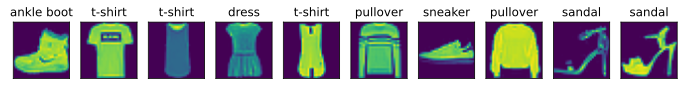

In [80]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

### 小批量读取图片

In [81]:
batch_size = 250
if sys.platform.startswith('win'):
    num_works = 0
else:
    num_works = 4

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_works)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_works)

start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

4.52 sec


## 实现SoftMax

### 加载数据

In [82]:

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型参数

In [101]:
num_inputs = 784
num_outputs = 10

# 生成参数与偏置
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W.shape

torch.Size([784, 10])

### 定义操作

In [99]:
# 从行维度和列维度进行sum运算
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)



(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [100]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition    # 使用了广播机制

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1), X.shape[0]

(tensor([[0.0126, 0.0913, 0.8515, 0.0377, 0.0068],
         [0.2205, 0.4004, 0.0503, 0.2301, 0.0988]]),
 tensor([1.0000, 1.0000]),
 torch.Size([2, 5]))

### 定义模型
通过网络映射到输出 首先用reshap将原始图像展平为向量

In [86]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W)+b)

### 定义损失函数

In [87]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0,1], y]     # 这样可以选到 第一行第0个 和 第二行第2个

tensor([0.1000, 0.5000])

In [88]:
# 交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度

In [89]:
def accuracy(y_hat, y):
    # 计算预测正确的数量
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


accuracy(y_hat, y) / len(y)

0.5

In [90]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [91]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [92]:
evaluate_accuracy(net, test_iter)

0.1107

### 训练

In [93]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类Animator， 它能够简化本书其余部分的代码。

In [94]:

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 实现训练函数

In [95]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

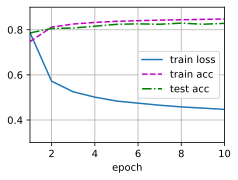

In [96]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

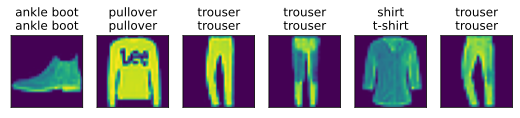

In [97]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)